In [33]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import json
from ast import literal_eval
import matplotlib.pyplot as plt

# Functions for Pipeline

In [34]:
def drop_categories(df):
    # this function drops all categories of API output which are irrelevant for prediction
    
    # delete unused columns
    df.drop(["dlc", "review_score_desc", "legal_notice", "recommendations", "ext_user_account_notice", "reviews", "metacritic", "demos", 
            "drm_notice", "alternate_appid", "screenshots", "movies", "support_info", "background", "background_raw", 
            "content_descriptors", "packages", "package_groups", "num_reviews", "developers", "achievements", 
            "detailed_description", "about_the_game", "supported_languages", "header_image", "website", 
            'appid', 'name', 'review_score', 'total_negative',
        'type', 'is_free', 'short_description',
       'pc_requirements', 'mac_requirements', 'linux_requirements',
       'publishers','controller_support', 'fullgame' 
            ], axis = 1, inplace=True)
    
    # unwanted genres
    gens = ['Design & Illustration', 'Audio Production', 'Photo Editing', 'Video Production', 'Game Development', 'Software Training',
                'Web Publishing', 'Animation & Modeling', 'Utilities']
    
    # german genres/categories
    german = ['Abenteuer', 'Aktion', 'Volle Controllerunterstützung', 'Steam-Errungenschaften', 'Einzelspieler', 'Remote Play auf Tablets',
              'Steam-Sammelkarten', 'Untertitel verfügbar', 'Plattformübergreifender Mehrspieler', 'Rollenspiel', 'Simulationen', 'Mehrspieler',
              'Online-Koop', 'Teilweise Controllerunterstützung', 'Koop']
    
    #remove rows of russian, german and unwanted genres
    df.drop(df[df[german + gens].isin([1]).any(axis=1)].index, inplace=True)

    # remove cols of russian, german and unwanted genres
    df.drop(german + gens, axis = 1, inplace=True)

In [35]:
def drop_few_review_games(df, num_reviews):
    # drop games with less than num_reviews reviews. also reset the index after dropping rows
    df =  df.loc[lambda df: df['total_reviews'] >= num_reviews, :]
    return df

In [36]:
def drop_high_price_games(df, max_price=200):
    # drops few outlier games which have unreasonably high prices. max price is price in euros (price/100)
    df=  df.loc[lambda df: df.price_overview/100 <= max_price, :]
    return df

In [37]:
def clean_col(df, col):
    # this function takes the API output of the column col categories and cleans it up
    # categories are shown in a list in new column "col_clean" in output dataframe
    
    # iterate through rows
    for index, row in df.iterrows():
        
        # prefilter games without price dict
        if col == "price_overview" and row.is_free:
            df[col].loc[index] = 0
        
        # try to read the entry as a dictionary
        try:
            dict = literal_eval(str(row[col]).replace("''",'None'))
        
        # if not possible delete row
        except: 
            df.drop(index, inplace=True)
        
        # if possible
        else:
            
            # get price
            if col == "price_overview":
                
                # if currency is not EUR
                if dict["currency"] != "EUR":
                    
                    # delete row
                    df.drop(index, inplace=True)
            
                # get price
                else:
                    df[col].loc[index] = dict["initial"]
            
            # or relase date
            elif col == "release_date":
        
                if dict['date'] == None:
                    df.drop(index, inplace=True)
                
                else:
                    #if exists, get year of release for game
                    df[col].loc[index] = dict["date"][-4:]
            # or                    
            else:
                categories = []
                
                # get platforms
                if col == "platforms":
                    categories = list({k: v for k, v in dict.items() if v}.keys())
                
                # or get categories/genres 
                else:
                    for j in range(len(dict)):
                        categories.append(dict[j]["description"])
                
                # insert values
                df[col].loc[index] = np.array(categories)
    
    return df

In [38]:
def get_set(df, col):
    # this function iterates through the new column "genres_clean" and return the set of unique genres contained in the dataframe
    G = []
    
    for idx,row in df.iterrows():
        
        for j in range(len(row[col])):
            G.append(row[col][j])
    
    return list(set(G))
        

In [39]:
def one_hot_encode(df, G, col):
    # this function creates a new column for each unique genre in the dataframe to one-hot-encode it.
    for j in G:
        df[j] = 0
    
    for idx,row in df.iterrows():
       for category in row[col]:
           df[category].loc[idx] = 1
    
    # drop old column
    df.drop(col, axis = 1, inplace=True)
    
    return df

In [40]:
def add_score(df):
    # adds the score column to the dataframe
    df["score"] = df["total_positive"]/df["total_reviews"]
    df.drop(["total_positive", "total_reviews"], axis = 1, inplace = True)
    df.reset_index(drop=True, inplace=True)
    return df

In [41]:
def join_columns(df, col1, col2):
    #integrates column2 into column1. 
    #Is done when correlation is high and one column is a generalization of the other
    
    # find out in which rows values of column1 and column 2 differ
    idx = np.where(df[col1]!=df[col2])
    # convert ot to usable index list such that it can be used as arugment for df.loc
    idx = list(df.loc[idx,col1].index)
    
    #in these rows, change value of column1 to 1. Then remove column 2 from dataframe
    df.loc[idx,col1]=1
    df.drop(col2, axis=1, inplace=True)

# Pipeline

In [42]:
df = pd.read_csv("raw_data.csv", index_col=0, low_memory=False)

In [43]:
df.columns

Index(['appid', 'name', 'num_reviews', 'review_score', 'review_score_desc',
       'total_positive', 'total_negative', 'total_reviews', 'type',
       'required_age', 'is_free', 'detailed_description', 'about_the_game',
       'short_description', 'supported_languages', 'header_image', 'website',
       'pc_requirements', 'mac_requirements', 'linux_requirements',
       'developers', 'publishers', 'price_overview', 'packages',
       'package_groups', 'platforms', 'categories', 'genres', 'screenshots',
       'movies', 'release_date', 'support_info', 'background',
       'background_raw', 'content_descriptors', 'controller_support',
       'achievements', 'legal_notice', 'recommendations', 'fullgame',
       'ext_user_account_notice', 'reviews', 'metacritic', 'demos', 'dlc',
       'drm_notice', 'alternate_appid'],
      dtype='object')

In [44]:
# clean and pre-process data

# drop games with insufficient reviews
df = drop_few_review_games(df, num_reviews=50)

# get clean price
df = clean_col(df, "price_overview")

# drop too expensice games
df = drop_high_price_games(df, max_price=200)

# get on-hot-encoded genres
df = clean_col(df, "genres")
genre_set = get_set(df, "genres")
df = one_hot_encode(df, genre_set, "genres")

# get on-hot-encoded categories
df = clean_col(df, "categories")
category_set = get_set(df, "categories")
df = one_hot_encode(df, category_set, "categories")

# clean genres and categories
drop_categories(df)

# get on-hot-encoded platforms
df = clean_col(df, "platforms")
platform_set = get_set(df, "platforms")
df = one_hot_encode(df, platform_set, "platforms")

# get release year
df = clean_col(df, "release_date")

# add score column
df = add_score(df)

# correct column names
df.rename(columns={"price_overview": "price", 'release_date': "relase_year"}, inplace = True)

# unite highly correlated/equal colmuns 
join_columns(df, "MMO", "Massively Multiplayer")
join_columns(df, "Violent", "Gore")
join_columns(df, "Remote Play on Phone", "Remote Play on Tablet")
join_columns(df, "PvP", "Online PvP")
join_columns(df, "VR Only", "Tracked Controller Support")
join_columns(df, "Co-op", "Online Co-op")
join_columns(df, "Shared/Split Screen", "Shared/Split Screen PvP")
join_columns(df, "Shared/Split Screen",'Shared/Split Screen Co-op')


/Users/emilbreustedt/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [45]:
df

,required_age,price,relase_year,Violent,Adventure,RPG,Action,Sports,Simulation,Racing,...,Includes level editor,Co-op,Commentary available,Additional High-Quality Audio,Steam Cloud,Steam Workshop,mac,linux,windows,score
0,0,1379,2021,0,0,0,0,1,1,0,...,0,0,0,0,0,0,0,0,1,0.955032
1,0,399,2021,0,1,0,1,0,0,0,...,0,1,0,0,0,0,0,0,1,0.733668
2,0,499,2021,0,0,0,1,0,1,0,...,0,0,0,0,0,0,0,0,1,0.921053
3,0,5999,2022,0,0,1,1,0,0,0,...,0,0,0,0,1,0,0,0,1,0.953191
4,0,799,2021,0,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,1,0.971429
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,0,599,2017,0,0,1,1,0,0,0,...,0,0,0,0,1,0,1,1,1,0.921875
9996,0,1679,2020,0,1,1,1,0,0,0,...,0,1,0,0,0,0,0,0,1,0.660407
9997,0,4999,2020,0,0,1,1,1,0,0,...,0,1,1,0,1,0,0,0,1,0.677665
9998,0,1999,2017,0,1,1,1,0,0,0,...,0,0,0,0,1,0,1,0,1,0.973799


In [46]:
df.columns

Index(['required_age', 'price', 'relase_year', 'Violent', 'Adventure', 'RPG',
       'Action', 'Sports', 'Simulation', 'Racing', 'Casual', 'Strategy',
       'Indie', 'Education', 'Nudity', 'Early Access', 'Sexual Content',
       'Free to Play', 'Remote Play Together', 'Multi-player', 'LAN Co-op',
       'PvP', 'Cross-Platform Multiplayer', 'VR Support',
       'Steam Turn Notifications', 'Partial Controller Support', 'MMO',
       'Steam Trading Cards', 'Includes Source SDK', 'SteamVR Collectibles',
       'Downloadable Content', 'Steam Leaderboards', 'Stats',
       'In-App Purchases', 'LAN PvP', 'VR Only', 'Valve Anti-Cheat enabled',
       'Remote Play on Phone', 'Captions available', 'Remote Play on TV',
       'Full controller support', 'Single-player', 'VR Supported',
       'Steam Achievements', 'Shared/Split Screen', 'Includes level editor',
       'Co-op', 'Commentary available', 'Additional High-Quality Audio',
       'Steam Cloud', 'Steam Workshop', 'mac', 'linux', 'window

In [47]:
df.to_csv('clean_data.csv')
df.sample(1000).to_csv('clean_data_small.csv')

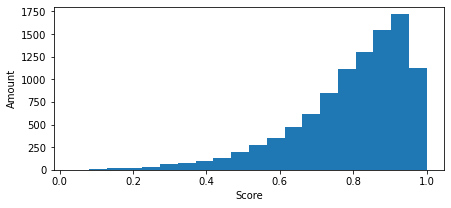

In [48]:
# plot distribution
plt.figure(figsize=(7,3))
plt.hist(df.score, bins=20)
plt.xlabel("Score")
plt.ylabel("Amount")
plt.savefig('score_dist.png', dpi=300, bbox_inches="tight")